# User Analysis

In here we are analysing the data in `data/users/`. Before pre-processing, **we have 341,018 users** that appear in our games network found in `data/games/network_raw`. 

After processing our dataframe so that we remove users that have invalid signup dates, **we now have 320,944 users**. **During this process we removed 74 users**. In the collection, if a user could not found by the speedrun.com API, we set their signup date as "Null". This is explained by users deleting their account, but their runs still being avaialble on the leaderboards. We can see that **the average user has only played ~2 different games**, with **half of all players only playing 1 game**. There are a lot of outliers (meaning more than 4 standard deviations away from mean). **The user `kj9521v8` or Jaypin88 has played 2059 games, and has completed 3033 runs**.

**Half of all users signed up before `2021-01-04`** which shows how the platform exploded in popularity in recent years. In other words, **it took two years to double the number of users that have played games on speedrun.com**.

After investigating the top 5 users ranked by the number of games they have played, they brand themselves as 'vareity speedrunners'. The top user `Jaypin88` has over 100,000 subscribers on his YouTube channel. Jaypin88's self-identified interests are old-school Sonic games, but he 'generally wants to be more open to different games old & new alike, so not from just one genre' [1]. There was actually a competition called "Gotta Run 'Em All" [2] for users to try and speedrun the most games. 

[1] - https://www.twitch.tv/Jaypin88/about
[2] - https://docs.google.com/document/d/1tTkaUHa_7imNU06cp9bka2lQalbJ0vw970wF6yKArlo/edit

In [222]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import networkx as nx
import networkx.algorithms.community as nx_comm

from datetime import datetime
from scipy import stats
from collections import Counter
from operator import itemgetter

import matplotlib

In [111]:
user_prefs_filename = "../data/users/user_preferences_with_metadata.csv"
user_prefs_df = pd.read_csv(user_prefs_filename)

In [112]:
user_prefs_df = user_prefs_df[(user_prefs_df['signup_date'].notna()) & (user_prefs_df['signup_date'] != "Null")]
user_prefs_df['signup_date'] = pd.to_datetime(user_prefs_df['signup_date'], format='%Y-%m-%dT%H:%M:%SZ')
user_prefs_df['signup_date'] = pd.to_datetime(user_prefs_df['signup_date'].dt.strftime('%Y-%m-%d'))
user_prefs_df = user_prefs_df[(user_prefs_df['signup_date'] < '2023-01-01')]

In [113]:
user_prefs_df.describe(include='all', datetime_is_numeric=True)

,user,signup_date,location,num_games,games
count,335322,335322,335322,335322.000000,335322
unique,335322,NaN,257,NaN,88806
top,j5wzz2qj,NaN,us,NaN,k6q4rqzd
freq,1,NaN,101439,NaN,5131
mean,NaN,2020-06-28 13:40:53.271780608,NaN,1.994465,NaN
min,NaN,2014-01-06 00:00:00,NaN,1.000000,NaN
25%,NaN,2019-09-16 00:00:00,NaN,1.000000,NaN
50%,NaN,2021-01-04 00:00:00,NaN,1.000000,NaN
75%,NaN,2021-09-25 00:00:00,NaN,2.000000,NaN
max,NaN,2022-12-31 00:00:00,NaN,2059.000000,NaN


In [114]:
user_prefs_df.sum(numeric_only=True)

num_games    668788
dtype: int64

In [115]:
remaining_users_df = user_prefs_df[(user_prefs_df['num_games'] > 1)]
remaining_users_df['num_games'].median()

3.0

In [116]:
user_prefs_df.sort_values(by='num_games').tail(20).iloc[::-1]

,user,signup_date,location,num_games,games
28,kj9521v8,2016-12-11,ca,2059,"m1mg3k12,pd0w42l1,m1zkm9m1,v1pxxw46,3dxkywy1,4..."
69,8qzo95o8,2020-03-25,us,1884,"y65k0e6e,9dow05o1,k6qwwpm6,3698yy3d,76rxe8q6,p..."
2658,y8dzlz9j,2019-04-26,us,916,"46w3pn31,m1zrx3d0,kdk9lx6m,9dow05o1,y65k0e6e,m..."
2704,68wne448,2019-11-11,br,658,"yd4k9x6e,2688056p,j1n5wl1p,yd43mp1e,j1n8nne1,2..."
298,j0n0vk48,2020-11-11,us,597,"kdkzexgd,lde58jd3,y654joed,kdk9lx6m,pdv27gr6,o..."
1,zxzygl4j,2017-07-26,us,589,"kdk9lx6m,m1zjjx26,m1meg4d2,y65ey86e,j1neg91p,p..."
2237,8ger577j,2020-01-22,us,469,"3dxrxydy,4d79e0l1,o6gg8n62,j1nee0l1,lderln63,o..."
320,zxzzvlrx,2018-02-25,jp,450,"ldej04e1,2688056p,36985w2d,yd4kyn56,369820ld,p..."
383,j51p0268,2021-01-28,us,445,"m1mn7ppd,m1mnmykd,pd0w42l1,369j481l,46w29k36,7..."
5055,qjn1wzw8,2017-10-09,us,443,"46w3pn31,m1zrx3d0,y65k0e6e,9dow05o1,9d3mj96l,7..."


In [8]:
del remaining_users_df, user_prefs_filename

## Locations of Users of speedrun.com

We can see from the graph **nearly a third of all speedrunners say that they live in the United States**. The next biggest demographic is users that did not set a location on their profile. For the remaining countries in the top 20 demographics, we must question why those countries in particular? Do these countries have similarities? What do these countries have that mean they have many speedrunners?

In [131]:
grouped_df = user_prefs_df.groupby(['location'])
grouped_sum_df = grouped_df.sum(numeric_only=True)
grouped_sum_df['number'] = grouped_df.count().iloc[:, 0]
grouped_sum_df.reset_index(inplace=True)
grouped_sum_df['location'] = grouped_sum_df['location'].str.upper()

In [125]:
grouped_sum_df.loc[grouped_sum_df['location'].isin(['GB', 'GB/ENG', 'GB/NIR', 'GB/WLS', 'GB/SCT']), 'location'] = 'GB'
grouped_sum_df.loc[grouped_sum_df['location'].isin(['CA', 'CA/QC']), 'location'] = 'CA'
grouped_sum_df.loc[grouped_sum_df['location'].isin(['ES', 'ES/CN', 'ES/CT', 'ES/PV']), 'location'] = 'ES'
grouped_sum_df = grouped_sum_df.groupby(['location']).sum(numeric_only=True).reset_index(inplace=False)

In [126]:
country_df = pd.read_csv("../data/users/countries_codes_and_coordinates.csv")
country_df = country_df[['Country', 'Alpha-2 code']].rename(columns={'Alpha-2 code': 'location', 'Country': 'country'})
country_df['location'] = country_df['location'].str.strip()
country_df['location'] = country_df['location'].str.replace('\"', '', -1)

In [127]:
merged_df = country_df.merge(grouped_sum_df, on='location', how='right')
merged_df = merged_df[merged_df.country != "Russian Federation"]
merged_df.sort_values(by='number').tail(15).iloc[::-1]

,country,location,num_games,number
238,United States,US,231617,101439
172,NaN,NONE,75708,58107
81,United Kingdom,GB,41008,20030
39,Canada,CA,41427,17135
79,France,FR,25789,12425
59,Germany,DE,24277,11794
12,Australia,AU,18675,9765
32,Brazil,BR,18609,8987
197,Russia,RU,15221,7534
184,Poland,PL,11667,5955


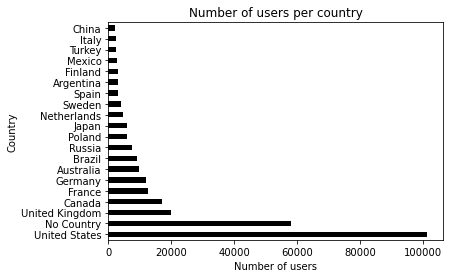

In [128]:
num_countries = 20
merged_df = merged_df.sort_values(by='number', ascending=False).head(num_countries)
merged_df['country'].iloc[1] = "No Country"

ax = merged_df.plot.barh(x='country', y='number', color='black')
ax.get_legend().remove()
ax.set_xlabel('Number of users')
ax.set_ylabel('Country')
ax.set_title('Number of users per country')

plt.show()

In [14]:
del country_df, grouped_df, grouped_sum_df, ax, merged_df, num_countries

## Signup Date of Users of speedrun.com

After grouping the users by their signup date, we can see that **there is a regular ebb and flow in the signup rate of users**. We can also visualise the explosion in popularity around 2020, and **peaking in daily signups around New Years day 2021**. To explain the increases in daily signups, we plot the events of Summer Games Done Quick (SGDQ) and Awesome Games Done Quick (AGDQ) in green and red respectively. **In general, there is an increase in signups post-GDQ**. 

**The "mystery event" in October/November 2020 could be the explosion in popularity of games like Among Us during the COVID-19 lockdowns**. Looking at revenue percentage changes from the years of 2017 - 2027, we see that the revenue percentage increase is extremely high during 2020 [1]. 

[1] - https://www.statista.com/forecasts/1275485/revenue-growth-video-game-united-states  

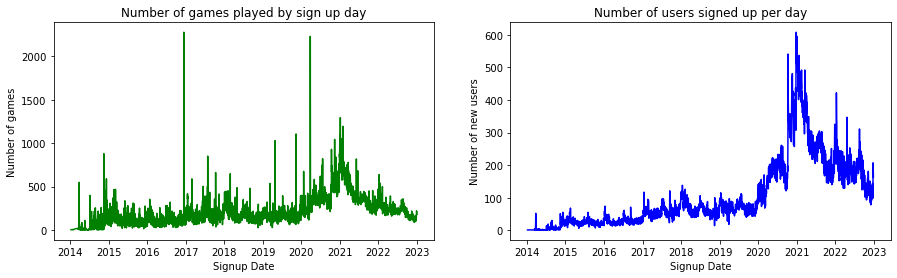

In [117]:
fig, ax = plt.subplots(1, 2)

df = user_prefs_df.copy().groupby(['signup_date']).sum().reset_index()
ax[0].plot(df['signup_date'], df['num_games'], color='green')
ax[0].set_xlabel("Signup Date")
ax[0].set_ylabel("Number of games")
ax[0].set_title("Number of games played by sign up day")

df = user_prefs_df.copy().groupby(['signup_date']).count().reset_index()
ax[1].plot(df['signup_date'], df['user'], color='blue')
ax[1].set_xlabel("Signup Date")
ax[1].set_ylabel("Number of new users")
ax[1].set_title("Number of users signed up per day")

fig.set_figwidth(15)
plt.show()

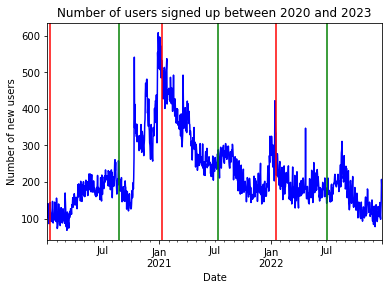

In [118]:
user_signup_2020_2023_df = df[(df['signup_date'] > '2020-01-01') & (df['signup_date'] < '2022-12-31')]

ax = user_signup_2020_2023_df.sort_values(by='signup_date').plot.line(x='signup_date', y='user', color='blue')

ax.axvline('2020-01-12', color='red')
ax.axvline('2021-01-10', color='red')
ax.axvline('2022-01-16', color='red')

ax.axvline('2020-08-23', color='green')
ax.axvline('2021-07-11', color='green')
ax.axvline('2022-07-03', color='green')

# What happened around here? I have no idea. Could be among us, fall guys, Dream, anything really.
# ax.axvline('2020-10-10', color='black')

ax.get_legend().remove()
ax.set_xlabel("Date")
ax.set_ylabel("Number of new users")
ax.set_title("Number of users signed up between 2020 and 2023")
plt.show()

In [188]:
tmp_df = user_prefs_df.copy()
tmp_df.reset_index(inplace=True)
tmp_df['location'] = tmp_df['location'].str.upper()
tmp_df.loc[tmp_df['location'].isin(['GB', 'GB/ENG', 'GB/NIR', 'GB/WLS', 'GB/SCT']), 'location'] = 'GB'
tmp_df.loc[tmp_df['location'].isin(['CA', 'CA/QC']), 'location'] = 'CA'
tmp_df.loc[tmp_df['location'].isin(['ES', 'ES/CN', 'ES/CT', 'ES/PV']), 'location'] = 'ES'
tmp_df

,index,user,signup_date,location,num_games,games
0,0,j5wzz2qj,2020-10-13,RU,123,"kdk9lx6m,pd0qj3l1,pdv2j746,kdkm93e1,y655m8e6,7..."
1,1,zxzygl4j,2017-07-26,US,589,"kdk9lx6m,m1zjjx26,m1meg4d2,y65ey86e,j1neg91p,p..."
2,2,8dw0vmlj,2020-04-11,NONE,7,"pd0wkv31,pd0oo3de,9dowr0m1,y65457de,pd0p526e,p..."
3,3,y8dk0kmj,2018-06-14,US,111,"268wmk6p,nd28x23d,j1lnke6g,lde3v563,v1pjjz18,3..."
4,4,o869v58z,2015-06-04,UA,96,"268wmk6p,kdk9lx6m,w6j5e41j,4d79jz17,9doye36p,3..."
...,...,...,...,...,...,...
335317,341013,j2ywkv68,2020-02-06,ZA,1,j1ngze6p
335318,341014,x3q9m52j,2021-03-22,US,1,j1ngze6p
335319,341015,8enzm978,2021-02-04,CA,1,j1ngze6p
335320,341016,48gqyd2j,2019-06-19,CH,1,j1ngze6p


In [225]:
top_countries = tmp_df.groupby('location').count().sort_values(by='user').tail(9).iloc[::-1].index.values.tolist()
print(f"Top Countries: {top_countries}")

Top Countries: ['US', 'NONE', 'GB', 'CA', 'FR', 'DE', 'AU', 'BR', 'RU']


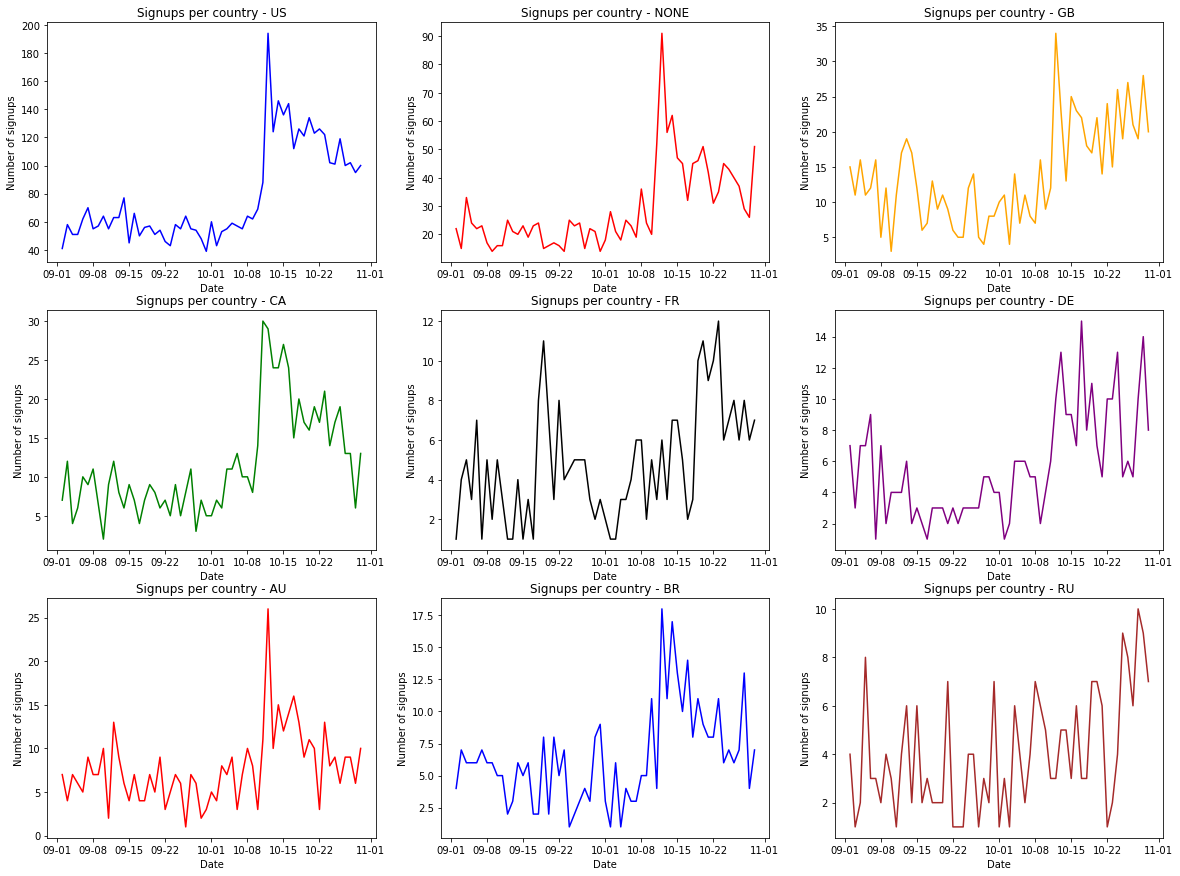

In [235]:
fig, ax = plt.subplots(3, 3)
colors = ['blue', 'red', 'orange', 'green', 'black', 'purple', 'red', 'blue', 'brown']

for index, top_country in enumerate(top_countries[:3]):
    df = tmp_df[(tmp_df['location'] == top_country)].copy().groupby(['signup_date']).count().reset_index()
    df = df[(df['signup_date'] > '2020-09-01') & (df['signup_date'] < '2020-10-31')]
    ax[0, index].plot(df['signup_date'], df['user'], colors[index])

    date_form = matplotlib.dates.DateFormatter("%m-%d")
    ax[0, index].xaxis.set_major_formatter(date_form)
    ax[0, index].set_title(f"Signups per country - {top_country}")
    ax[0, index].set_xlabel('Date')
    ax[0, index].set_ylabel('Number of signups')

for index, top_country in enumerate(top_countries[3:6]):
    df = tmp_df[(tmp_df['location'] == top_country)].copy().groupby(['signup_date']).count().reset_index()
    df = df[(df['signup_date'] > '2020-09-01') & (df['signup_date'] < '2020-10-31')]
    ax[1, index].plot(df['signup_date'], df['user'], colors[index+3])

    date_form = matplotlib.dates.DateFormatter("%m-%d")
    ax[1, index].xaxis.set_major_formatter(date_form)
    ax[1, index].set_title(f"Signups per country - {top_country}")
    ax[1, index].set_xlabel('Date')
    ax[1, index].set_ylabel('Number of signups')

for index, top_country in enumerate(top_countries[6:9]):
    df = tmp_df[(tmp_df['location'] == top_country)].copy().groupby(['signup_date']).count().reset_index()
    df = df[(df['signup_date'] > '2020-09-01') & (df['signup_date'] < '2020-10-31')]
    ax[2, index % 3].plot(df['signup_date'], df['user'], colors[index+6])

    date_form = matplotlib.dates.DateFormatter("%m-%d")
    ax[2, index].xaxis.set_major_formatter(date_form)
    ax[2, index].set_title(f"Signups per country - {top_country}")
    ax[2, index].set_xlabel('Date')
    ax[2, index].set_ylabel('Number of signups')
    
fig.set_figheight(15)
fig.set_figwidth(20)
plt.show()

In [17]:
del df, user_signup_2020_2023_df, ax, fig

# Types of User on speedrun.com

After analysing the user present in the games network, we see that **there is a power law between the number of users that have played an amount of games**. Upon removing outliers from our data, we can see that **there are no obvious clusters present in the games played by users vs. the amount of time they have been on the platform**. There is also **no correlation between time registered and number of games played**. We can see that **player behaviour is very similar for 334,352 users**. This behaviour is that **for 99.99% of players, they have played less than 32 games**.

In [18]:
user_type_df = user_prefs_df.copy()
user_type_df['time_registered'] = (datetime(2023, 1, 1) - user_type_df['signup_date']) / np.timedelta64(1, 'D')

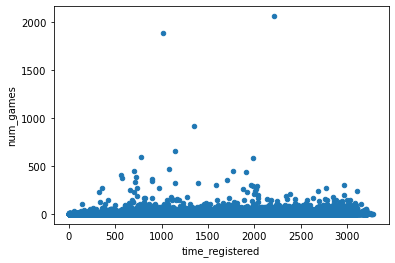

In [19]:
user_type_df.plot.scatter(x='time_registered', y='num_games')
plt.show()

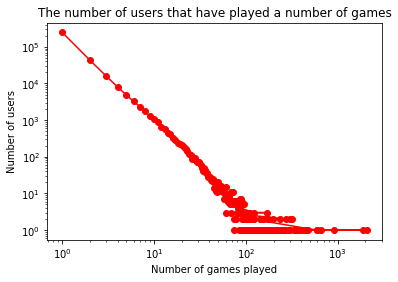

In [20]:
num_games, num_users = list(zip(*sorted(Counter(user_type_df['num_games']).items(), key=itemgetter(1), reverse=True)))
plt.loglog(num_games, num_users, 'ro-')
plt.xlabel("Number of games played")
plt.ylabel("Number of users")
plt.title("The number of users that have played a number of games")
plt.show()

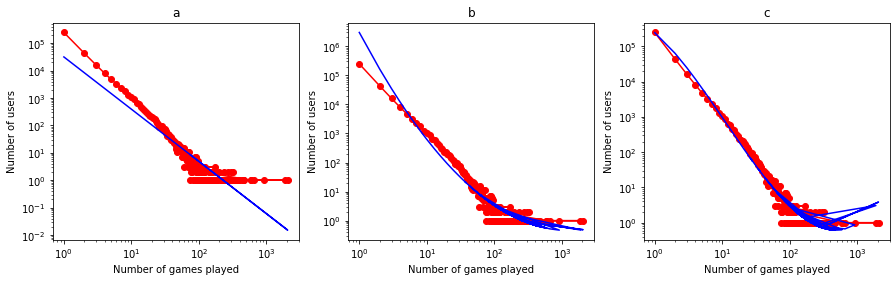

In [21]:
num_games, num_users = list(zip(*sorted(Counter(user_type_df['num_games']).items(), key=itemgetter(1), reverse=True)))
log_x = np.log(np.array(num_games))
log_y = np.log(np.array(num_users))

fig, ax = plt.subplots(1, 3)

a, b = np.polyfit(log_x, log_y, 1)
y_fit = np.exp(a*log_x + b)
ax[0].loglog(num_games, num_users, 'ro-')
ax[0].loglog(num_games, y_fit, 'b-')
ax[0].set_xlabel("Number of games played")
ax[0].set_ylabel("Number of users")
ax[0].set_title("a")

a, b, c = np.polyfit(log_x, log_y, 2)
y_fit = np.exp(a*log_x**2 + b*log_x + c)
ax[1].loglog(num_games, num_users, 'ro-')
ax[1].loglog(num_games, y_fit, 'b-')
ax[1].set_xlabel("Number of games played")
ax[1].set_ylabel("Number of users")
ax[1].set_title("b")

a, b, c, d = np.polyfit(log_x, log_y, 3)
y_fit = np.exp(a*log_x**3 + b*log_x**2 + c*log_x + d)
ax[2].loglog(num_games, num_users, 'ro-')
ax[2].loglog(num_games, y_fit, 'b-')
ax[2].set_xlabel("Number of games played")
ax[2].set_ylabel("Number of users")
ax[2].set_title("c")

fig.set_figwidth(15)
plt.show()

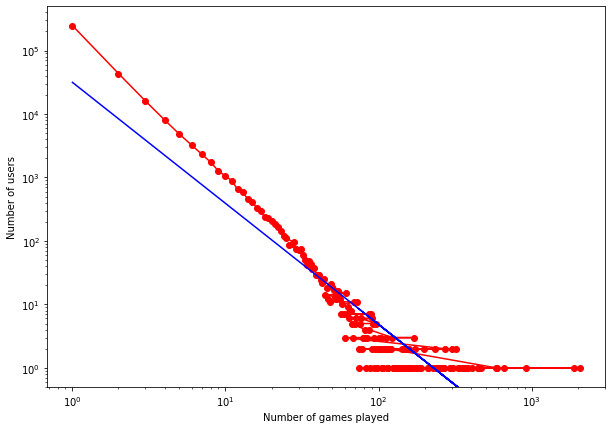

In [22]:
num_games, num_users = list(zip(*sorted(Counter(user_type_df['num_games']).items(), key=itemgetter(1), reverse=True)))
log_x = np.log(np.array(num_games))
log_y = np.log(np.array(num_users))

fig, ax = plt.subplots(1, 1)

a, b = np.polyfit(log_x, log_y, 1)
y_fit = np.exp(a*log_x + b)
ax.loglog(num_games, num_users, 'ro-')
ax.loglog(num_games, y_fit, 'b-')
ax.set_xlabel("Number of games played")
ax.set_ylabel("Number of users")
ax.set_ylim(ymin=0.5, ymax=max(num_users)*2)

fig.set_figheight(7)
fig.set_figwidth(10)
plt.show()


In [23]:
print(f"{a=}, {b=}, {np.exp(b)=}")
print(np.exp(b)*(1**a))

a=-1.9069834073094856, b=10.358571120395785, np.exp(b)=31526.10211947771
31526.10211947771


We have a power law in terms of $y=e^b * x^a$. Where $b=10.36$ (4 s.f.) and $a=-1.907$ (4 s.f.). This is simplified to $y=31526.10*x^{-1.91}$

Cutoff: 31.637231172266702


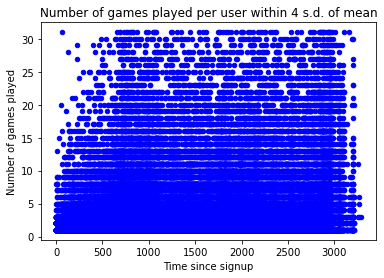

In [25]:
mean = user_type_df['num_games'].mean()
sd = user_type_df['num_games'].std()
n_std = 4

print(f"Cutoff: {mean+(n_std*sd)}")
ax = user_type_df[(user_type_df['num_games'] <= mean+(n_std*sd))].plot.scatter(x='time_registered', y='num_games', c='blue')
ax.set_ylabel("Number of games played")
ax.set_xlabel("Time since signup")
ax.set_title("Number of games played per user within 4 s.d. of mean")
plt.show()

In [26]:
user_type_df[(user_type_df['num_games'] <= mean+(n_std*sd))].describe(include='all', datetime_is_numeric=True)

,user,signup_date,location,num_games,games,time_registered
count,334352,334352,334352,334352.000000,334352,334352.000000
unique,334352,NaN,257,NaN,87836,NaN
top,8dw0vmlj,NaN,us,NaN,k6q4rqzd,NaN
freq,1,NaN,101050,NaN,5131,NaN
mean,NaN,2020-07-01 09:25:03.689524480,NaN,1.795889,NaN,913.607596
min,NaN,2014-01-06 00:00:00,NaN,1.000000,NaN,1.000000
25%,NaN,2019-09-24 00:00:00,NaN,1.000000,NaN,462.000000
50%,NaN,2021-01-05 00:00:00,NaN,1.000000,NaN,726.000000
75%,NaN,2021-09-26 00:00:00,NaN,2.000000,NaN,1195.000000
max,NaN,2022-12-31 00:00:00,NaN,31.000000,NaN,3282.000000


Cutoff: 513.9403483488021


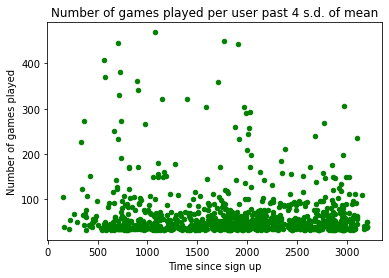

In [27]:
top_users_df = user_type_df[(user_type_df['num_games'] > mean+(n_std*sd))]
mean = top_users_df['num_games'].mean()
sd = top_users_df['num_games'].std()
n_std = 4

print(f"Cutoff: {mean+(n_std*sd)}")
ax = top_users_df[(top_users_df['num_games'] <= mean+(n_std*sd))].plot.scatter(x='time_registered', y='num_games', c='g')
ax.set_title("Number of games played per user past 4 s.d. of mean")
ax.set_xlabel("Time since sign up")
ax.set_ylabel("Number of games played")
plt.show()

In [28]:
top_users_df.describe(include='all', datetime_is_numeric=True)

,user,signup_date,location,num_games,games,time_registered
count,970,970,970,970.000000,970,970.000000
unique,970,NaN,79,NaN,970,NaN
top,j5wzz2qj,NaN,us,NaN,"kdk9lx6m,pd0qj3l1,pdv2j746,kdkm93e1,y655m8e6,7...",NaN
freq,1,NaN,389,NaN,1,NaN
mean,NaN,2017-10-29 17:29:34.020618752,NaN,70.442268,NaN,1889.271134
min,NaN,2014-03-25 00:00:00,NaN,32.000000,NaN,147.000000
25%,NaN,2015-11-10 06:00:00,NaN,36.000000,NaN,1152.750000
50%,NaN,2017-09-05 12:00:00,NaN,45.000000,NaN,1943.500000
75%,NaN,2019-11-05 06:00:00,NaN,66.000000,NaN,2608.750000
max,NaN,2022-08-07 00:00:00,NaN,2059.000000,NaN,3204.000000


In [29]:
del top_users_df, mean, sd, n_std, a, b, c, d, fig, ax, num_games, num_users, log_x, log_y, user_type_df, y_fit

## Games that Users play on speedrun.com

We find that there are **246,995 players that have only played one game on speedrun.com**. **The games that these players play are Seterra, Minecraft-related games, ROBLOX-related games, Nintendo games, and 'typical speedrun' games**. 

We can see that **out of 43,367 users that have played strictly two games, the most popular combination is `nd2e9erd, j1npme6p`**. These are Minecraft: Java Edition category extensions, and Minecraft: Java Edition respectively. The combination of `o1ymwk1q, o1y9wo6q` represents Super Mario 64 and it's category extensions respectively. **These combinations seem to be either a game and it's category extensions, a game and it's sequel, or two games related to a single entity**. An example of the last one is Hypixel Bridging and Hypixel Bedwars.

### Games for Users that have Played One Game

In [30]:
one_game_user_df = user_prefs_df[(user_prefs_df['num_games'] == 1)].rename(columns={'games': 'id'})
games_metadata_df = pd.read_csv("../data/games/metadata/all_games_srcom.csv").rename(columns = {'game_id': 'id'})
one_game_user_df = one_game_user_df.groupby('id').count().reset_index()
merged_df = one_game_user_df.merge(games_metadata_df, on='id', how='inner')

In [31]:
user_prefs_df[(user_prefs_df['num_games'] == 1)].rename(columns={'games': 'id'}).count()['user']

246995

In [32]:
user_prefs_df[(user_prefs_df['num_games'] == 1)].rename(columns={'games': 'id'}).groupby('id').count().reset_index().sum()['user']

246995

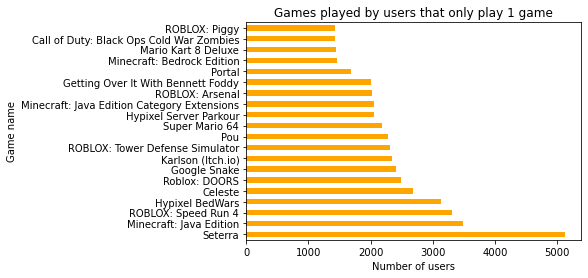

In [33]:
number_of_values = 20
merged_df = merged_df[['game_name', 'num_games']].sort_values(
    by='num_games').tail(number_of_values).iloc[::-1]
ax = merged_df.plot.barh(x='game_name', y='num_games', color='orange')
ax.set_xlabel("Number of users")
ax.set_ylabel("Game name")
ax.set_title("Games played by users that only play 1 game")
ax.get_legend().remove()
plt.show()

### Games for Users that have played Only Two Games

In [34]:
two_game_user_df = user_prefs_df[(user_prefs_df['num_games'] == 2)].rename(columns={'games': 'id'})
two_game_user_df = two_game_user_df.groupby('id').count().reset_index()
two_game_user_df = two_game_user_df[['id', 'num_games']].sort_values(by='num_games').tail(number_of_values).iloc[::-1]

In [35]:
user_prefs_df[(user_prefs_df['num_games'] == 2)].rename(columns={'games': 'id'}).count()['user']

43367

In [36]:
user_prefs_df[(user_prefs_df['num_games'] == 2)].rename(columns={'games': 'id'}).groupby('id').count().reset_index().sum()['user']

43367

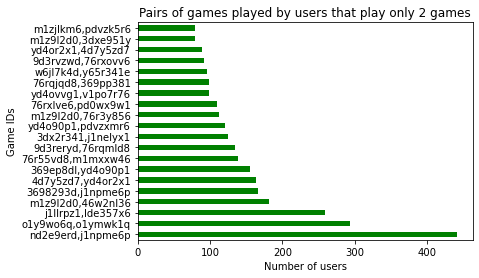

In [37]:
ax = two_game_user_df.plot.barh(x='id', y='num_games', color='green')
ax.set_xlabel("Number of users")
ax.set_ylabel("Game IDs")
ax.get_legend().remove()
ax.set_title("Pairs of games played by users that play only 2 games")
plt.show()

### Overrall Most Popular Games

In [38]:
games_df = user_prefs_df.copy()
games_df['games'] = games_df['games'].str.split(',')
games_df = games_df.explode('games').rename(columns = {'games': 'id'})
games_df = games_df.groupby('id').count().reset_index().sort_values(by='num_games').tail(20).iloc[::-1]

In [39]:
games_metadata_df = pd.read_csv("../data/games/metadata/all_games_srcom.csv").rename(columns={'game_id': 'id'})
games_df = games_df.merge(games_metadata_df, on='id', how='inner')

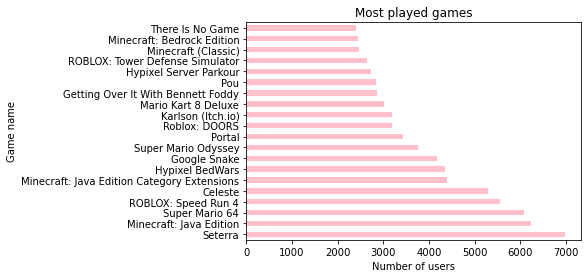

In [40]:
ax = games_df.plot.barh(x='game_name', y='num_games', color='pink')
ax.get_legend().remove()
ax.set_xlabel("Number of users")
ax.set_ylabel("Game name")
ax.set_title("Most played games")
plt.show()

### Games Played by Users Within 3 s.d. of Mean

In [102]:
mean = user_prefs_df['num_games'].mean()
sd = user_prefs_df['num_games'].std()
n_std = 3
bottom_games_df = user_prefs_df[(user_prefs_df['num_games'] <= mean+(sd*n_std))].copy()
print(f"Number of users: {bottom_games_df.count()['user']}")

Number of users: 333751


In [103]:
bottom_games_df['games'] = bottom_games_df['games'].str.split(',')
bottom_games_df = bottom_games_df.explode('games').rename(columns = {'games': 'id'})
bottom_games_df = bottom_games_df.groupby('id').count().reset_index().sort_values(by='num_games')

In [104]:
games_metadata_df = pd.read_csv("../data/games/metadata/all_games_srcom.csv").rename(columns={'game_id': 'id'})
merged_df = bottom_games_df.merge(games_metadata_df, on='id', how='inner')
merged_df.tail().iloc[::-1]

,id,user,signup_date,location,num_games,game_name,developers,release_date,created_date,num_categories,num_levels,num_runs,num_users,num_guests
27433,k6q4rqzd,6817,6817,6817,6817,Seterra,"4eppvoer,ne410dem",1997-01-01,2018-09-27T08:29:37Z,29,903,61962,7168,36
27432,j1npme6p,6186,6186,6186,6186,Minecraft: Java Edition,k62d97ex,2011-11-18,2015-01-29T23:41:21Z,15,0,18329,6268,491
27431,o1y9wo6q,5844,5844,5844,5844,Super Mario 64,xv6dvx62,1996-06-23,None,6,15,33895,6118,452
27430,pd0py36e,5474,5474,5474,5474,ROBLOX: Speed Run 4,yzol0kzq,2013-01-01,2015-10-14T00:39:39Z,9,33,11303,5636,20
27429,o1y9j9v6,5161,5161,5161,5161,Celeste,1zk4q26j,2018-01-25,2018-01-15T20:23:45Z,15,9,32317,5406,14


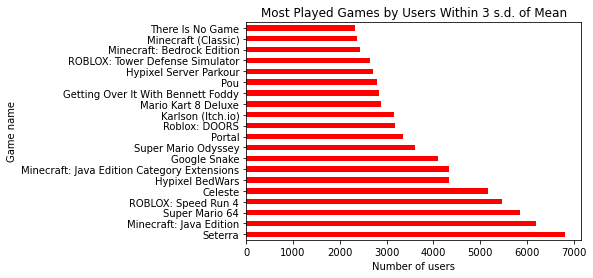

In [105]:
ax = merged_df.tail(20).iloc[::-1].plot.barh(x='game_name', y='user', color='red')
ax.get_legend().remove()
ax.set_xlabel("Number of users")
ax.set_ylabel("Game name")
ax.set_title("Most Played Games by Users Within 3 s.d. of Mean")
plt.show()

### Games Played by Users Outside of 3 s.d. of Mean

In [106]:
mean = user_prefs_df['num_games'].mean()
sd = user_prefs_df['num_games'].std()
n_std = 3
top_games_df = user_prefs_df[(user_prefs_df['num_games'] > mean+(sd*n_std))].copy()
print(f"Number of users: {top_games_df.count()['user']}")

Number of users: 1571


In [107]:
top_games_df['games'] = top_games_df['games'].str.split(',')
top_games_df = top_games_df.explode('games').rename(columns = {'games': 'id'})
top_games_df = top_games_df.groupby('id').count().reset_index().sort_values(by='num_games')

In [108]:
games_metadata_df = pd.read_csv("../data/games/metadata/all_games_srcom.csv").rename(columns={'game_id': 'id'})
merged_df = top_games_df.merge(games_metadata_df, on='id', how='inner')
merged_df.tail().iloc[::-1]

,id,user,signup_date,location,num_games,game_name,developers,release_date,created_date,num_categories,num_levels,num_runs,num_users,num_guests
21240,o1y9wo6q,229,229,229,229,Super Mario 64,xv6dvx62,1996-06-23,None,6,15,33895,6118,452
21239,om1m3625,203,203,203,203,Super Mario Bros.,xv6dvx62,1985-09-13,None,5,0,8018,1737,31
21238,pd0wq31e,178,178,178,178,Super Mario World,xv6dvx62,1990-11-21,None,13,0,9820,1830,38
21237,9d3rr0dl,166,166,166,166,The Legend of Zelda: A Link to the Past,xv6dvx62,1991-11-21,None,4,0,7949,2063,46
21236,k6q4rqzd,162,162,162,162,Seterra,"4eppvoer,ne410dem",1997-01-01,2018-09-27T08:29:37Z,29,903,61962,7168,36


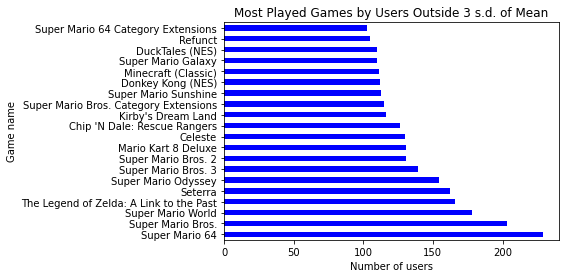

In [109]:
ax = merged_df.tail(20).iloc[::-1].plot.barh(x='game_name', y='user', color='blue')
ax.get_legend().remove()
ax.set_xlabel("Number of users")
ax.set_ylabel("Game name")
ax.set_title("Most Played Games by Users Outside 3 s.d. of Mean")
plt.show()

In [71]:
del ax, games_df, merged_df, games_metadata_df, number_of_values, one_game_user_df, two_game_user_df

## Community Detection of Users on speedrun.com

In [4]:
user_prefs_df = pd.read_csv("../data/users/user_preferences_with_metadata.csv")
user_prefs_df = user_prefs_df[(user_prefs_df['signup_date'].notna()) & (user_prefs_df['signup_date'] != "Null")]
user_prefs_df['signup_date'] = pd.to_datetime(user_prefs_df['signup_date'], format='%Y-%m-%dT%H:%M:%SZ')
user_prefs_df['signup_date'] = pd.to_datetime(user_prefs_df['signup_date'].dt.strftime('%Y-%m-%d'))
user_prefs_df = user_prefs_df[(user_prefs_df['signup_date'] < '2023-01-01')]

In [5]:
user_prefs_df.describe(include='all', datetime_is_numeric=True)

,user,signup_date,location,num_games,games
count,335322,335322,335322,335322.000000,335322
unique,335322,NaN,257,NaN,88806
top,j5wzz2qj,NaN,us,NaN,k6q4rqzd
freq,1,NaN,101439,NaN,5131
mean,NaN,2020-06-28 13:40:53.271780608,NaN,1.994465,NaN
min,NaN,2014-01-06 00:00:00,NaN,1.000000,NaN
25%,NaN,2019-09-16 00:00:00,NaN,1.000000,NaN
50%,NaN,2021-01-04 00:00:00,NaN,1.000000,NaN
75%,NaN,2021-09-25 00:00:00,NaN,2.000000,NaN
max,NaN,2022-12-31 00:00:00,NaN,2059.000000,NaN
